In [1]:
# ! pip install torch_geometric

In [2]:
import os
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import DenseGCNConv, dense_diff_pool
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import sys

from torch_geometric.datasets import Entities, TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj


from utils import *
from model import *

/Users/stella/anaconda3/envs/gdl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load Dataset
# dataset = Entities(root='data/Entities', name='MUTAG')
# dataset = TUDataset(root='data/TUDataset', name='MUTAG')
dataset = TUDataset(root='data/TUDataset', name='Mutagenicity')

# max_nodes = 150
# class MyFilter(object):
#     def __call__(self, data):
#         return data.num_nodes <= max_nodes
# dataset = TUDataset(root='data/TUDataset', name='Mutagenicity', transform=T.ToDense(max_nodes), pre_filter=MyFilter())

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# data = dataset[0]  # Get the first graph object.

# print()
# print(data)
# print('=============================================================')

# Gather some statistics about the first graph.
# print(f'Number of nodes: {data.num_nodes}')
# print(f'Number of edges: {data.num_edges}')
# print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Has isolated nodes: {data.has_isolated_nodes()}')
# print(f'Has self-loops: {data.has_self_loops()}')
# print(f'Is undirected: {data.is_undirected()}')


Dataset: Mutagenicity(4337):
Number of graphs: 4337
Number of features: 14
Number of classes: 2


In [4]:
torch.manual_seed(12345)

# Train test split
train_split = 0.8
batch_size = 16
train_loader, test_loader, visual_data_loader = prepare_data(dataset, train_split, batch_size)


Class split - Training 0: 1901 1: 1568, Test 0: 500 1: 368


In [5]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for data in loader:
        adj = to_dense_adj(data.edge_index, data.batch)
        batched_x = pad_features(data)
        
        optimizer.zero_grad()

        out, l, e, _, _, _, _, _, _ = model(batched_x, adj)
        
        loss = criterion(out, data.y) + l + e
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

In [6]:
def test(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for data in loader:
            adj = to_dense_adj(data.edge_index, data.batch)
            batched_x = pad_features(data)

            out, _, _, _, _, _, _, _, _= model(batched_x, adj, data.batch)
            
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.max(dim=1)[1]
            correct += pred.eq(data.y).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset)

In [7]:
model = DiffPoolGNN(dataset.num_features, dataset.num_classes)  
# model = Mutag_GCN_DiffPool8(dataset.num_features, dataset.num_classes)  


lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

Epoch 1, Train Loss: 3.4811, Test Loss: 0.6653, Test Acc: 0.6244
Epoch 2, Train Loss: 3.4702, Test Loss: 0.6566, Test Acc: 0.6371
Epoch 3, Train Loss: 3.4139, Test Loss: 0.6352, Test Acc: 0.6302
Epoch 4, Train Loss: 3.3746, Test Loss: 0.5725, Test Acc: 0.7108
Epoch 5, Train Loss: 3.3318, Test Loss: 0.5652, Test Acc: 0.7028
Epoch 6, Train Loss: 3.3224, Test Loss: 0.6321, Test Acc: 0.6740
Epoch 7, Train Loss: 3.3096, Test Loss: 0.6023, Test Acc: 0.7200
Epoch 8, Train Loss: 3.3143, Test Loss: 0.5858, Test Acc: 0.7039
Epoch 9, Train Loss: 3.2918, Test Loss: 0.5562, Test Acc: 0.7339
Epoch 10, Train Loss: 3.2938, Test Loss: 0.5765, Test Acc: 0.7074
Epoch 11, Train Loss: 3.2806, Test Loss: 0.5400, Test Acc: 0.7350
Epoch 12, Train Loss: 3.2716, Test Loss: 0.5347, Test Acc: 0.7385
Epoch 13, Train Loss: 3.2753, Test Loss: 0.5339, Test Acc: 0.7546
Epoch 14, Train Loss: 3.2660, Test Loss: 0.5525, Test Acc: 0.7454
Epoch 15, Train Loss: 3.2630, Test Loss: 0.5257, Test Acc: 0.7512
Epoch 16, Train Los

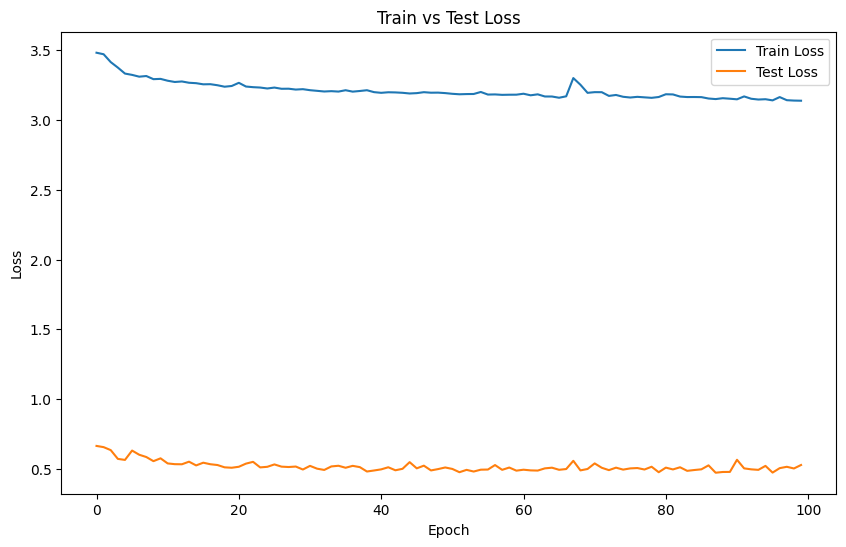

In [8]:
epochs = 100
train_losses = []
test_losses = []

for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc = test(model, test_loader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.show()

In [9]:
torch.save(model.state_dict(), 'model_state_dict_new.pth')

### Load trained model

In [10]:
model0 = DiffPoolGNN(dataset.num_features, dataset.num_classes)    # Initialize model
model0.load_state_dict(torch.load('model_state_dict_new.pth'))
model0.eval()  # Set the model to inference mode


DiffPoolGNN(
  (conv1): DenseGCNConv(14, 32)
  (conv2): DenseGCNConv(32, 32)
  (conv3): DenseGCNConv(32, 32)
  (conv4): DenseGCNConv(32, 32)
  (conv5): DenseGCNConv(32, 32)
  (conv6): DenseGCNConv(32, 32)
  (pool1): DiffPool(
    (gnn1_pool): GNN(
      (convs): ModuleList(
        (0): DenseGCNConv(32, 32)
        (1): DenseGCNConv(32, 32)
        (2): DenseGCNConv(32, 8)
      )
      (bns): ModuleList()
    )
    (gnn1_embed): GNN(
      (convs): ModuleList(
        (0): DenseGCNConv(32, 32)
        (1): DenseGCNConv(32, 32)
        (2): DenseGCNConv(32, 32)
      )
      (bns): ModuleList()
    )
  )
  (pool2): DiffPool(
    (gnn1_pool): GNN(
      (convs): ModuleList(
        (0): DenseGCNConv(32, 32)
        (1): DenseGCNConv(32, 32)
        (2): DenseGCNConv(32, 2)
      )
      (bns): ModuleList()
    )
    (gnn1_embed): GNN(
      (convs): ModuleList(
        (0): DenseGCNConv(32, 32)
        (1): DenseGCNConv(32, 32)
        (2): DenseGCNConv(32, 32)
      )
      (bns): Modu

## DiffPool Visualization

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans


# Get the actual number of nodes in each graph of the visual_data_batch
# len(graph_node) = batch size of visual data loader
def real_graph_node(visual_data_batch):
    graph_nodes = []
    batch_size = len(visual_data_batch)
    for i in range(batch_size):
        graph_nodes.append(visual_data_batch[i].num_nodes)
    return graph_nodes


def kmeans_clustering(features, k):
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(features)
    # Get cluster labels and centroids
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    return labels, centroids


# Dimension Reduction for 2D visualization
def dimension_reduction(features_np, DR_method):
    if DR_method == 'PCA':
        pca = PCA(n_components=2)
        features_DR = pca.fit_transform(features_np)
    elif DR_method == 'TSNE':
        tsne = TSNE(n_components=2)
        features_DR = tsne.fit_transform(features_np)
    elif DR_method == 'UMAP':
        reducer = umap.UMAP(n_components=2)
        features_DR = reducer.fit_transform(features_np)
    return features_DR

In [12]:

# Visualization of the activation space before the first DiffPool layer
# Coloring according to K-means clustering of the raw activation space
def before_first_diffpool_plot(activation_space_before, graph_nodes, DR_method, k):
    """
    Input:
        activation_space_before: B * N * num_hidden_units
        graph_nodes: len() = B, containing the real number of nodes in each graph
        DR_method: 'PCA' or 'TSNE' or 'UMAP'
        k: cluster number for K-means clustering
    """
    relevant_features = []
    for idx, real_node_number in enumerate(graph_nodes):
        # Extract the features for the relevant nodes in the graph
        relevant_features.append(activation_space_before[idx, :real_node_number, :])
    # Concatenate all the relevant features along the first dimension
    features = torch.cat(relevant_features, dim=0)

    # Convert to numpy for dimensionality reduction
    features_np = features.detach().cpu().numpy()

    # K-means clustering of the raw activation space to get clustering labels for each node
    labels, centroids = kmeans_clustering(features_np, k)

    # Apply Dimension Reduction
    features_DR = dimension_reduction(features_np, DR_method)


    # ========================== Plotting Activation Space ==========================

    # Generate a colormap with distinct colors
    colors = plt.cm.jet(np.linspace(0, 1, k))

    # plt.figure(figsize=(8, 6))

    for i, label in enumerate(range(k)):
        idx = labels == label
        plt.scatter(features_DR[idx, 0], features_DR[idx, 1], color=colors[i], label=f'Cluster {label}')

    plt.xlabel(f'{DR_method} Component 1')
    plt.ylabel(f'{DR_method} Component 2')
    plt.title(f'{DR_method} Visualization of Activation Space before First DiffPool')
    # Place the legend outside the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # Adjust subplot parameters to give some space for the legend
    plt.subplots_adjust(right=0.75)
    plt.show()            
        
    return

In [16]:

def after_first_diffpool_plot(activation_space_after, graph_nodes, cluster_assignments, DR_method, k):

    batch_size, num_dp_clusters, _ = activation_space_after.shape

    relevant_cluster_assignments = []
    for idx, real_node_number in enumerate(graph_nodes):
        # Extract diffpooled cluster labels for each graph
        relevant_cluster_assignments.append(torch.unique(cluster_assignments[idx, :real_node_number]))


    relevant_features = []
    for b in range(batch_size):
        for c in relevant_cluster_assignments[b]:
            relevant_features.append(activation_space_after[b, int(c), :])
    
    
    # Stack the tensors
    features = torch.stack(relevant_features)
    # Convert to numpy array
    features_np = features.detach().cpu().numpy()

    # K-means clustering of the raw activation space to get clustering labels for each node
    labels_km, centroids = kmeans_clustering(features_np, k)

    # Apply Dimension Reduction
    features_DR = dimension_reduction(features_np, DR_method)


    # Deal with diffpooled cluster labels
    labels_dp = torch.cat(relevant_cluster_assignments).detach().cpu().numpy()
    

    # ========================== Plotting Activation Space (no clustering) ==========================
    plt.figure()
    plt.scatter(features_DR[:, 0], features_DR[:, 1])
    plt.xlabel(f'{DR_method} Component 1')
    plt.ylabel(f'{DR_method} Component 2')
    plt.title(f'{DR_method} Visualization of Activation Space after First DiffPool')
    plt.show()            

    # ========================== Plotting Activation Space (K-Means colored) ==========================
    
    # Generate a colormap with distinct colors according to k-means clusters
    colors_km = plt.cm.jet(np.linspace(0, 1, k))

    plt.figure()
    for i, label in enumerate(range(k)):
        idx = labels_km == label
        plt.scatter(features_DR[idx, 0], features_DR[idx, 1], color=colors_km[i], label=f'Cluster {label}')

    plt.xlabel(f'{DR_method} Component 1')
    plt.ylabel(f'{DR_method} Component 2')
    plt.title(f'{DR_method} Visualization of Activation Space after First DiffPool (K-Means colored)')
    # Place the legend outside the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # Adjust subplot parameters to give some space for the legend
    plt.subplots_adjust(right=0.75)
    plt.show()   

    # ========================== Plotting Activation Space (Diff-Pooling colored) ==========================  
           
    # Generate a colormap with distinct colors according to diffpool clusters
    colors_dp = plt.cm.jet(np.linspace(0, 1, num_dp_clusters)) 

    plt.figure()
    for i, label in enumerate(range(num_dp_clusters)):
        idx = labels_dp == label
        plt.scatter(features_DR[idx, 0], features_DR[idx, 1], color=colors_dp[i], label=f'Cluster {label}')

    plt.xlabel(f'{DR_method} Component 1')
    plt.ylabel(f'{DR_method} Component 2')
    plt.title(f'{DR_method} Visualization of Activation Space after First DiffPool (DiffPool colored)')
    # Place the legend outside the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # Adjust subplot parameters to give some space for the legend
    plt.subplots_adjust(right=0.75)
    plt.show()  

    return

/Users/stella/anaconda3/envs/gdl/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


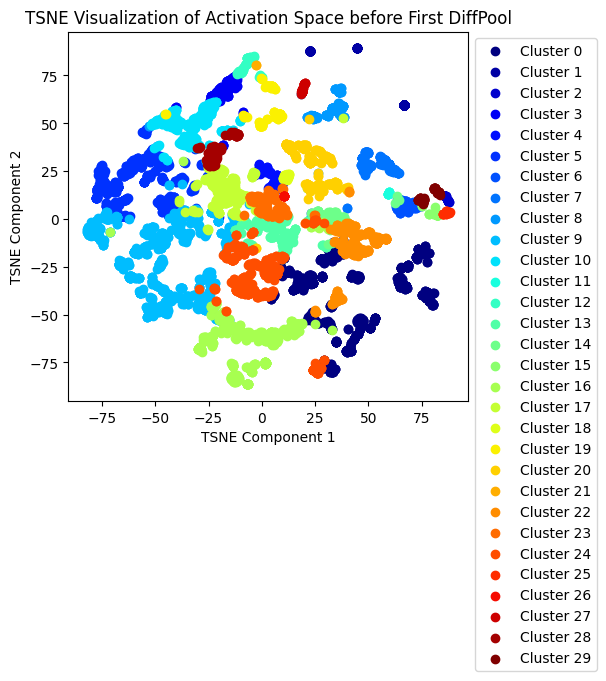

/Users/stella/anaconda3/envs/gdl/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


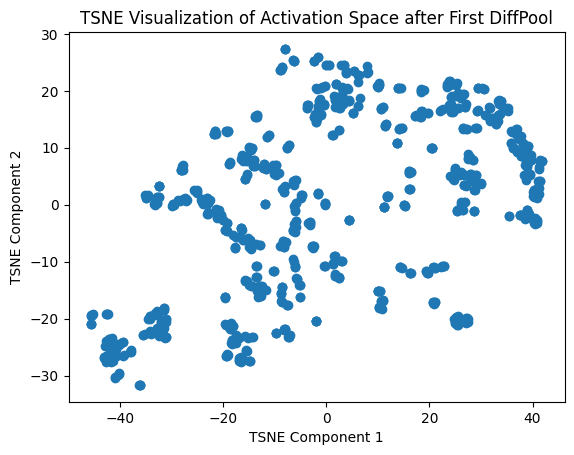

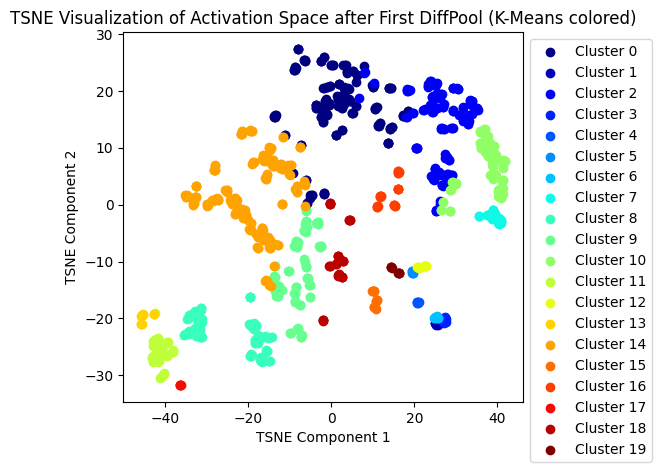

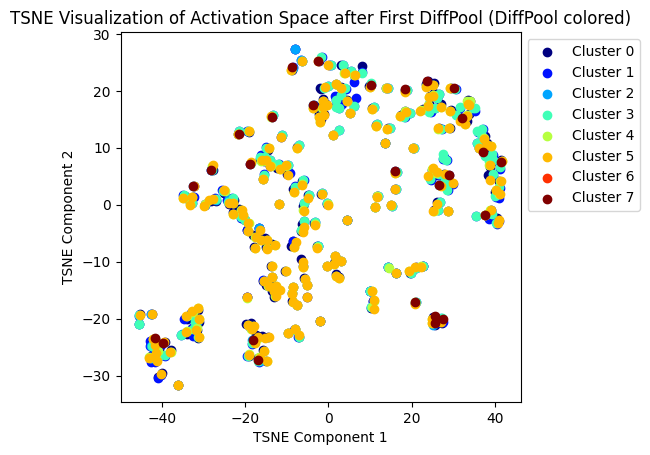

In [17]:
for data in visual_data_loader:
    
    adj = to_dense_adj(data.edge_index, data.batch)
    batched_x = pad_features(data)
    
    graph_nodes = real_graph_node(data)
    
    out, _, _, out1, cluster_assignments1, out2, cluster_assignments2, out1before, out2before = model0(batched_x, adj, data.batch)
    
    break


before_first_diffpool_plot(out1before, graph_nodes, 'TSNE', 30)

after_first_diffpool_plot(out1, graph_nodes, cluster_assignments1, 'TSNE', 20)

### Some Graph Ploting Trial (Please Ignore)

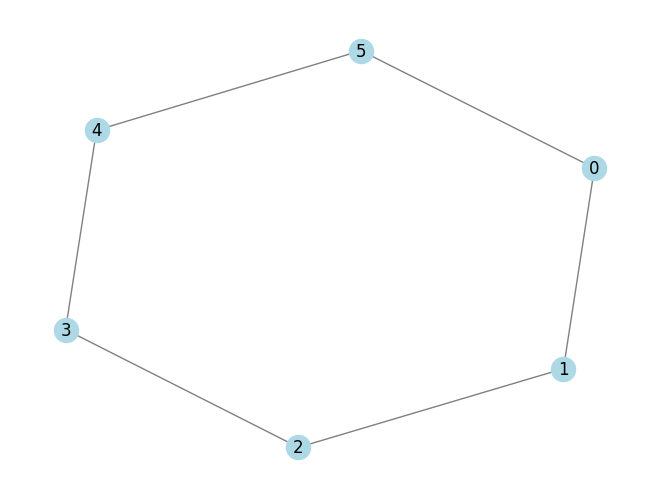

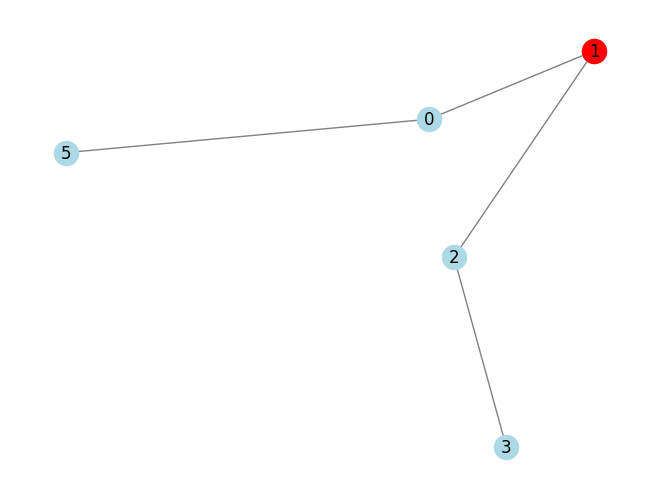

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


def two_hop_neighbor(adj_matrix, target_node):
    """
    Input:
        adj_matrix
        target_node: target node idx for which we want to find the 2-hop neighborhood
    """
    # Create a graph
    G = nx.Graph()

    # Add edges based on the adjacency matrix
    n = len(adj_matrix)
    for i in range(n):
        for j in range(n):
            if adj_matrix[i][j] == 1:
                G.add_edge(i, j)

    # Draw the graph
    nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
    plt.show()

    
    # Find the 1-hop neighbors
    one_hop_neighbors = set(nx.neighbors(G, target_node))

    # Find the 2-hop neighbors
    two_hop_neighbors = set()
    for neighbor in one_hop_neighbors:
        two_hop_neighbors |= set(nx.neighbors(G, neighbor))

    # Combine 1-hop and 2-hop neighbors, and include the target node itself
    neighborhood = one_hop_neighbors | two_hop_neighbors | {target_node}

    # Create the subgraph
    subgraph = G.subgraph(neighborhood)

    # Draw the subgraph
    pos = nx.spring_layout(subgraph)  # positions for all nodes
    nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray')

    # Highlight the target node
    nx.draw_networkx_nodes(subgraph, pos, nodelist=[target_node], node_color='red')

    plt.show()


# Example Adjacency Matrix
adj_matrix = np.array([[0, 1, 0, 0, 0, 1],[1, 0, 1, 0, 0, 0],[0, 1, 0, 1, 0, 0],[0, 0, 1, 0, 1, 0],[0, 0, 0, 1, 0, 1], [1, 0, 0, 0, 1, 0]])
two_hop_neighbor(adj_matrix, 1)
